# under construction

## Some examples using the tools in this distribution.

### Contents

- Load an image, and downsample to a size appropriate for the machine speed.
- Synthetic images.
- Point operations (lookup tables)
- histogram Modification/matching
- Convolution routines
- Compare speed of convolution/downsampling routines
- Display image and extension of left and top boundaries
- Multi-scale pyramids (see TUTORIALS/01_pyramids.ipynb)
    - A Laplacian pyramid
    - Wavelet/QMF pyramids
    - Steerable pyramid
    - Steerable pyramid, constructed in frequency domain

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyrtools as ppt

%load_ext autoreload
%autoreload 2

## Load an image, and downsample to a size appropriate for the machine speed

In [2]:
oim = plt.imread('../pyrtools/data/einsteinCorrect.pgm').astype(float)

In [3]:
import time
t = time.time()
ppt.corrDn(oim, filt=np.ones((2,2)) / 4, edges='reflect1', step=(2, 2), start=(0, 0), stop=None, result=None)
elapsed = time.time() - t

In [4]:
imSubSample = min(max(np.floor(np.log2(elapsed)/2+3),0),2)
# imSubSample = 1

In [5]:
im = ppt.blurDn(oim, n_levels=imSubSample, filt='qmf9')

ShowIm: 3 types of automatic graylevel scaling, 2 types of automatic sizing, with or without title and Range information.

In [6]:
? ppt.showIm

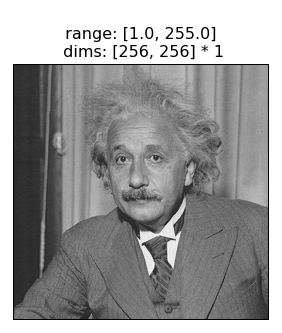

In [7]:
ppt.showIm(im);

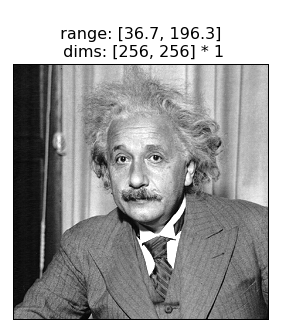

In [8]:
ppt.showIm(im, vrange='auto2');
# TODO
# ppt.showIm([oim,im], zoom=[1,2], title=['original', 'subsampled'], vrange='auto2', col_wrap=2);

In [9]:
# TODO
# plt.figure(figsize=(15,15))
# ax1 = plt.subplot(1,2,1)
# ax2 = plt.subplot(1,2,2)
# ppt.showIm(im, ax= ax1)
# ppt.showIm(oim, ax= ax2);

## Statistics:

In [10]:
ppt.imStats(im)
ppt.imCompare(im, oim)

Image statistics:
  Range: [1.000000, 255.000000]
  Mean: 116.456772,  Stdev: 39.899688,  Kurtosis: 3.433610
Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): inf


## Synthetic images

In [11]:
# pick some parameters
size      = 256
direction = 2 * np.pi * np.random.rand(1)
slope     = 10 * np.random.rand(1) - 5
intercept = 10 * np.random.rand(1) - 5
origin    = np.round(size * np.random.rand(2,1)).astype(int)
exponent  = 0.8 + np.random.rand(1)
amplitude = 1 + 5 * np.random.rand(1)
phase     = 2 * np.pi * np.random.rand(1)
period    = 20
twidth    = 7

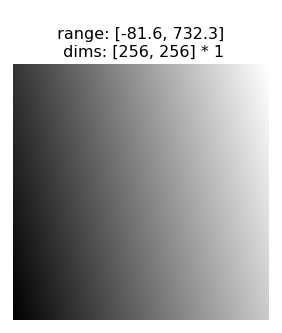

In [12]:
ppt.showIm(ppt.mkRamp(size, direction, slope, intercept, origin));

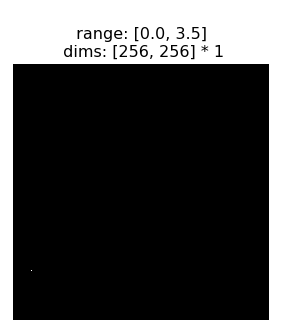

In [13]:
ppt.showIm(ppt.mkImpulse(size, origin, amplitude));

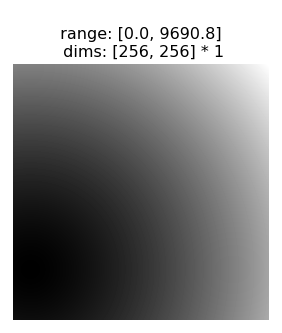

In [14]:
ppt.showIm(ppt.mkR(size, exponent, origin));

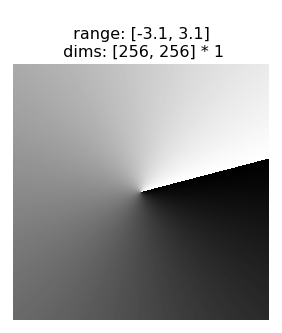

In [15]:
ppt.showIm(ppt.mkAngle(size, direction));

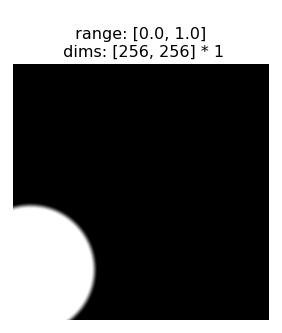

In [16]:
ppt.showIm(ppt.mkDisc(size, size/4, origin, twidth));

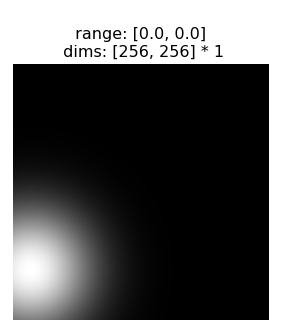

In [17]:
ppt.showIm(ppt.mkGaussian(size, (size/6)**2, origin, 'norm'));

In [18]:
# TODO fix normalization - range
g = ppt.mkGaussian(size, (size/6)**2, origin, 'norm')
g.min(), g.max()

(1.486461148445479e-16, 8.742642137616321e-05)

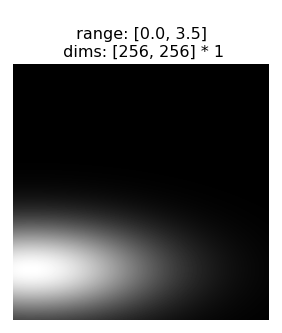

In [19]:
ppt.showIm(ppt.mkGaussian(size, ((size/8)**2,(size/3)**2), origin, amplitude));

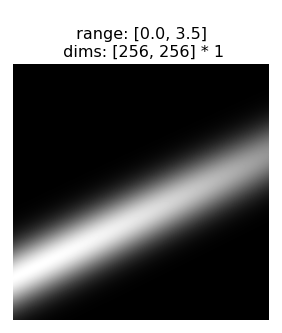

In [20]:
# cov = (size * np.random.uniform(-1,1,(2,2)))
# cov = cov.dot(cov.T)
# print(np.round(cov))
cov = np.array((( 12571., -25233.),
                (-25233.,  52488.)))

ppt.showIm(ppt.mkGaussian(size, cov, origin, amplitude));

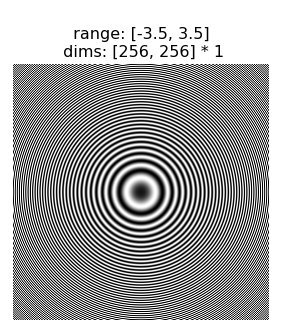

In [21]:
ppt.showIm(ppt.mkZonePlate(size, amplitude, phase));

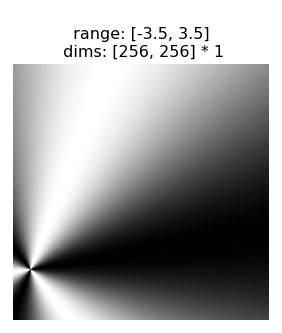

In [22]:
ppt.showIm(ppt.mkAngularSine(size, 3, amplitude, phase, origin));

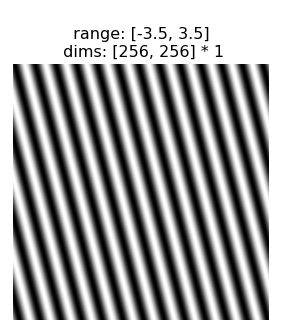

In [23]:
ppt.showIm(ppt.mkSine(size, period, direction, amplitude=amplitude, phase=phase, origin=origin));

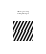

In [24]:
ppt.showIm(ppt.mkSine(20, frequency=[1,2]));

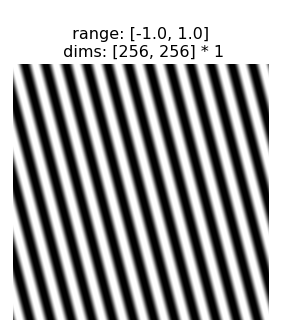

In [25]:
ppt.showIm(ppt.mkSquare(size, period, direction, amplitude, phase=phase, origin=origin, twidth=twidth));

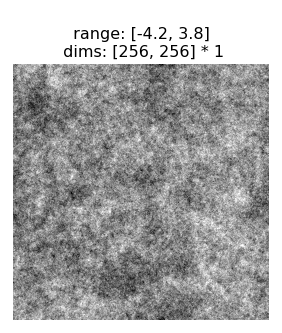

In [26]:
ppt.showIm(ppt.mkFract(size, exponent));

## Point operations (lookup tables):

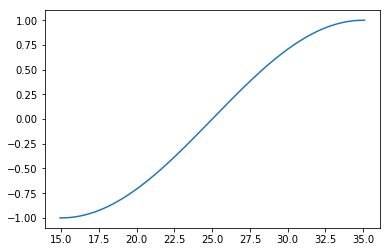

In [27]:
Xtbl,Ytbl = ppt.rcosFn(width=20, position=25, values=(-1, 1))
plt.plot(Xtbl,Ytbl)
plt.show()

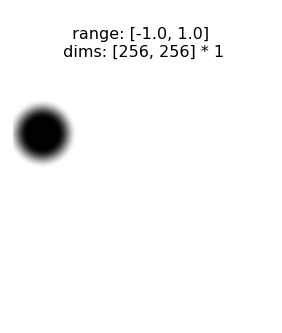

In [28]:
ppt.showIm(ppt.pointOp(ppt.mkR(size,1,[70,30]), Ytbl, Xtbl[0], Xtbl[1]-Xtbl[0], 0));

## histogram Modification/matching:

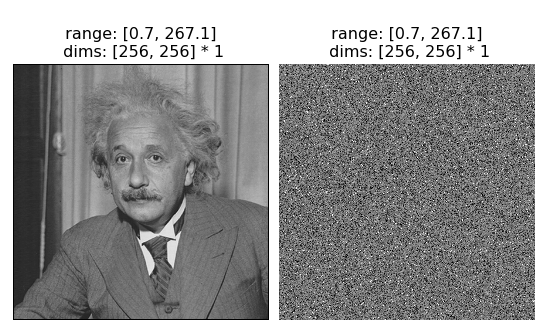

In [29]:
N, X    = ppt.matlab_histo(im, nbins=150)
mn, mx  = ppt.range2(im)

matched = ppt.histoMatch(np.random.uniform(size=im.shape), N, X)

ppt.showIm([im,matched]);

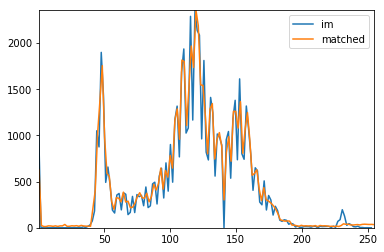

In [30]:
Nm, Xm = ppt.matlab_histo(matched,nbins=150)

plt.figure()
plt.plot(X.flatten()[:-1],N.flatten())
plt.plot(Xm.flatten()[:-1],Nm.flatten())
plt.xlim([mn, mx])
plt.ylim([0, np.max(N)])
plt.legend(['im','matched'])
plt.show()

In [31]:
# TODO 
# fix error in histoMatch

## Convolution routines: Compare speed of convolution/downsampling routines

In [32]:
k = 5
size = 2 ** 9
noise = np.random.rand(size,size)
filt  = np.random.rand(k,k)

In [33]:
%%time
res1 = ppt.corrDn(noise, np.flipud(np.fliplr(filt)), 'reflect1', step=[2, 2])

CPU times: user 1.04 ms, sys: 3.68 ms, total: 4.72 ms
Wall time: 4.53 ms


In [34]:
%%time
ires = ppt.rconv2(noise,filt)
res2 = ires[0:size:2,0:size:2]

CPU times: user 8.2 ms, sys: 20.2 ms, total: 28.4 ms
Wall time: 28.2 ms


In [35]:
ppt.imCompare(res1, res2)

Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): 287.373595


In [36]:
res3 = ppt.corrDn(noise, np.flipud(np.fliplr(filt)), 'reflect1', step=[1, 1])
ppt.imCompare(res3, ires)

Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): 287.419184


In [37]:
# TODO
# compare directly to to scipy.signal?

import scipy.signal as sps

res4 = sps.convolve2d(noise, filt, mode='same', boundary='symm')

ppt.imCompare(res4, ires)

Difference statistics:
  Range: [-1, 1]
  Mean: -0.000271,  Stdev (rmse): 0.054112,  SNR (dB): 21.664131


## Display image and extension of left and top boundaries:

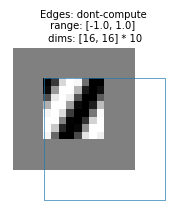

In [38]:
fsz = [9, 9]
fmid = np.ceil((fsz[0]+1)/2)
imsz = (16, 16)

# pick one:
im = np.eye(imsz[0])
im = ppt.mkRamp(imsz, np.pi/6)
im = ppt.mkSquare(imsz, 6, np.pi/6)

# pick one:
edges='reflect1'
edges='reflect2'
edges='repeat'
edges='extend'
edges='zero'
edges='circular'
edges='dont-compute'

filt = ppt.mkImpulse(fsz,[0, 0])
ppt.showIm(ppt.corrDn(im,filt,edges), zoom=10, title='Edges: ' + str(edges))
# TODO
plt.plot([0,0,imsz[1],imsz[1],0]+fmid-1.5,
         [0,imsz[0],imsz[0],0,0]+fmid-1.5, lw=.5)
plt.show()

## Pyramids

In [39]:
im = oim

Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): inf


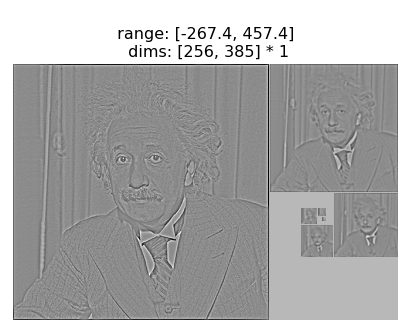

In [40]:
pyr = ppt.LaplacianPyramid(im)
pyr.showPyr()
res = pyr.reconPyr()
ppt.imCompare(im,res)

Difference statistics:
  Range: [0, 0]
  Mean: -0.194466,  Stdev (rmse): 0.085144,  SNR (dB): 53.416318


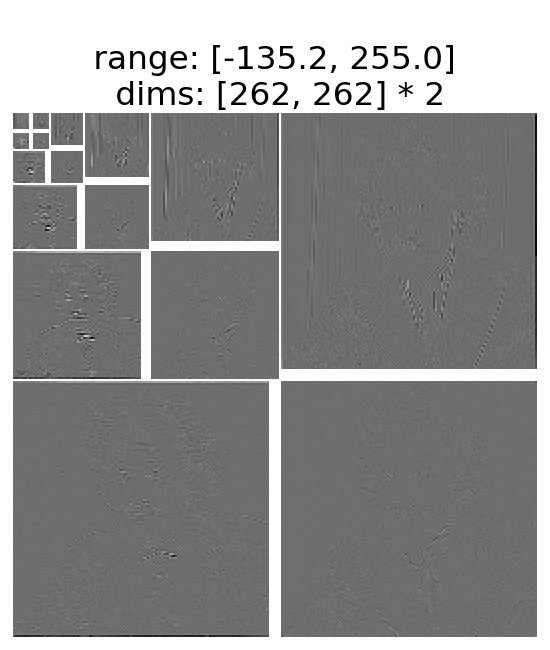

In [41]:
pyr = ppt.Wpyr(im)
pyr.showPyr()
res = pyr.reconPyr()
ppt.imCompare(im,res)

Difference statistics:
  Range: [-116, 35]
  Mean: -1.152866,  Stdev (rmse): 8.760636,  SNR (dB): 13.168677


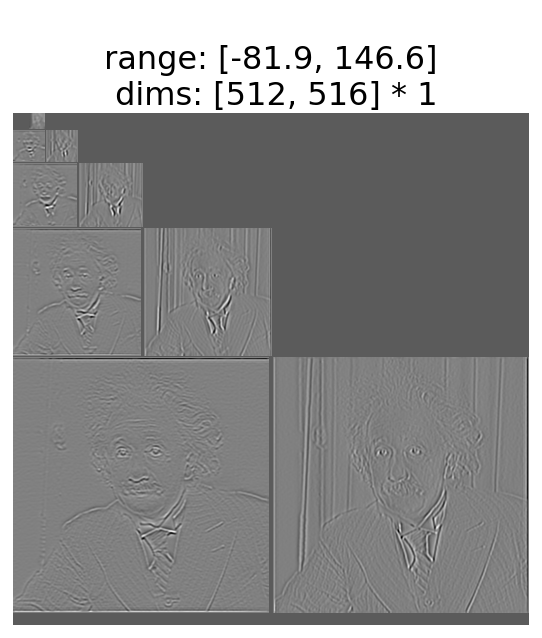

In [42]:
pyr = ppt.Spyr(im)
pyr.showPyr()
res = pyr.reconPyr()
ppt.imCompare(im,res)

In [43]:
# TODO
# error with some filters: 242 index 2 is out of bounds
# pyr = ppt.Spyr(im, filter='sp3Filters')
# pyr.showPyr()
# res = pyr.reconPyr()
# ppt.imCompare(im,res)

Difference statistics:
  Range: [0, 0]
  Mean: -0.000000,  Stdev (rmse): 0.000272,  SNR (dB): 103.316114


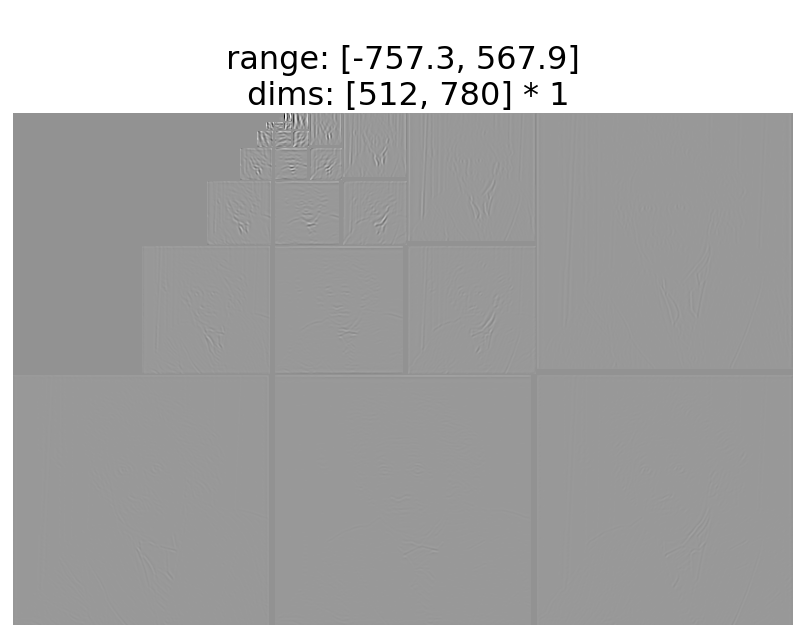

In [44]:
pyr = ppt.SFpyr(im) #, height=2, order=2
pyr.showPyr()
res = pyr.reconPyr()
ppt.imCompare(im,res)

In [45]:
# TODO
# 392 Casting complex values to real discards the imaginary part
# pyr = ppt.SCFpyr(im)
# pyr.showPyr()
# res = pyr.reconPyr()
# ppt.imCompare(im,res)

In [46]:
# TODO
# decide what range is printed in title
# pyr.showPyr()
# pyr.showPyr(prange='indep1')
# pyr.showPyr(prange='indep2')